In [3]:
from itertools import combinations, permutations
import numpy as np
import pandas as pd
from source.moreka import AxonData
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics.pairwise import euclidean_distances
# from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
# from scipy.stats import poisson
# import tensorflow as tf
# from tensorflow import keras
# from keras.layers import Input, LSTM, RepeatVector
# from keras.models import Model
from sklearn.mixture import BayesianGaussianMixture
# import mdn
# import plotly.express as px
from sympy import symbols, Eq, solve
# from sim import generate, moving_average

In [96]:
data_index = 36
n_ions = 3
n_components = n_ions + 1

(6000,)


<Axes: xlabel='time', ylabel='signal'>

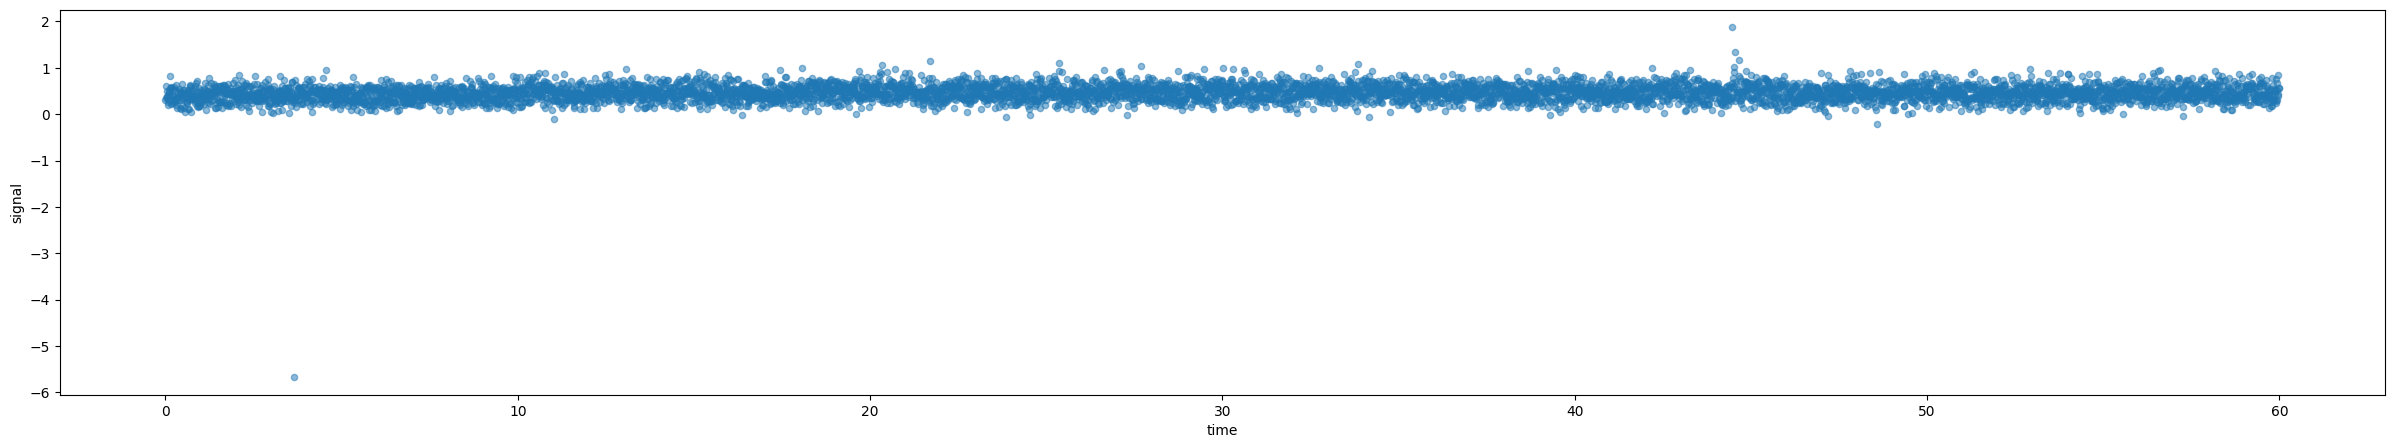

In [97]:
data = AxonData(dirname='./data')
df = data[data_index].iloc[::100, :]

print(df.signal.shape)
df.plot(x='time', y='signal', figsize=(30, 5), kind='scatter', alpha=0.5)

In [88]:
bgm = BayesianGaussianMixture(n_components=n_components, random_state=42).fit(df.signal.values.reshape(-1, 1))
bgm.means_

array([[0.45530502],
       [1.48306425],
       [2.07870825],
       [0.91040538]])

In [89]:
predicted = bgm.predict(df.signal.values.reshape(-1, 1))
df['predicted'] = predicted
conf = bgm.predict_proba(df.signal.values.reshape(-1, 1))
# desc sort conf axis
conf = np.sort(conf, axis=1)[:, ::-1]
df['conf'] = conf[:, 0]

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_5033/163554814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_5033/163554814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]


<Axes: xlabel='time', ylabel='signal'>

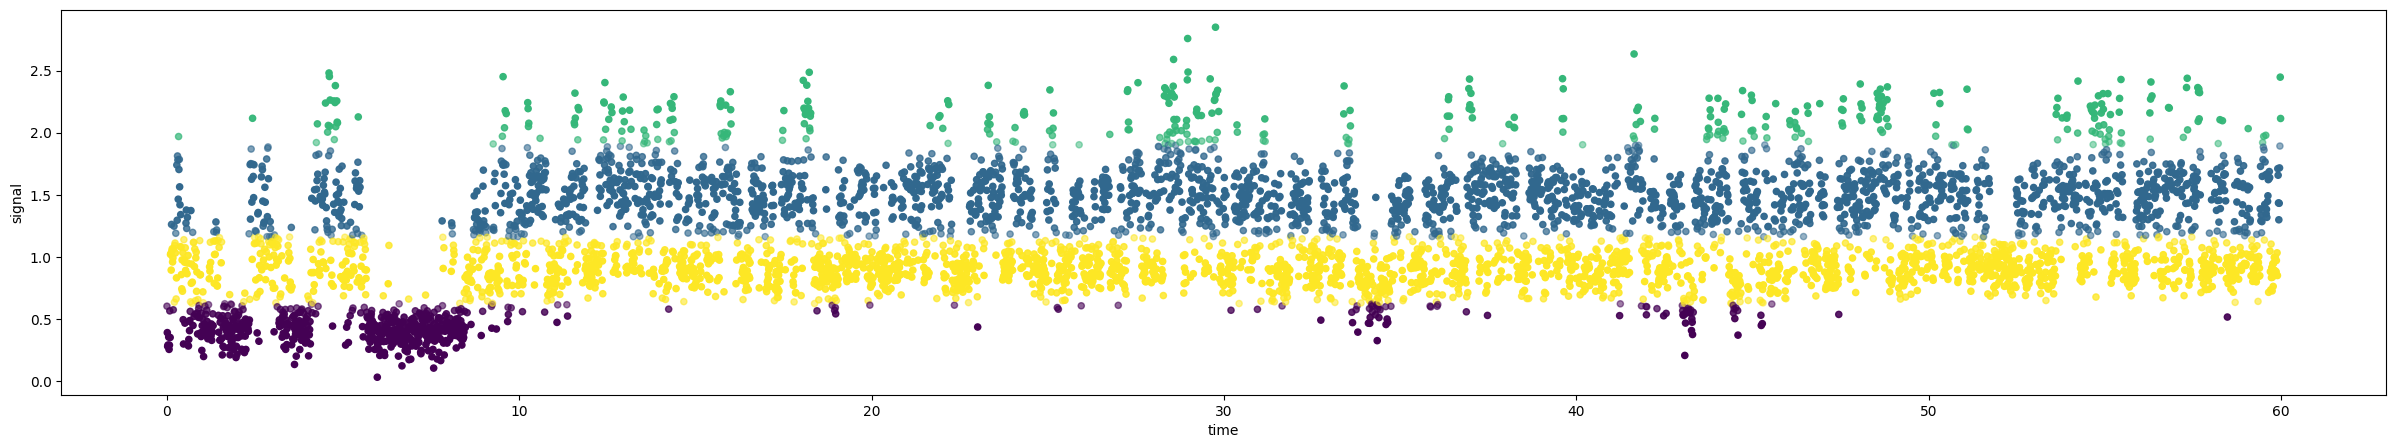

In [90]:
# limit x to 0-1
df.plot(x='time', y='signal', figsize=(30, 5), kind='scatter', alpha=df.conf, c='predicted', cmap='viridis',
        colorbar=False)

# plot the mean baselines
# plt.plot(df.time, [bgm.means_[i] for i in predicted], c='r')

In [91]:
df

time    signal  predicted      conf
0        0.00  0.603027          0  0.621481
100      0.01  0.390320          0  0.996073
200      0.02  0.279846          0  0.999698
300      0.03  0.290527          0  0.999613
400      0.04  0.279541          0  0.999700
...       ...       ...        ...       ...
599500  59.95  1.431885          1  0.997181
599600  59.96  1.716614          1  0.932673
599700  59.97  1.892700          1  0.534547
599800  59.98  2.447510          2  0.999740
599900  59.99  2.114563          2  0.957634

[6000 rows x 4 columns]

In [61]:
# average conf
df.conf.mean()

0.9295579521670746

In [62]:
for state_index in range(n_components):
    print(f'Probability of cluster {state_index}: {(df[df.predicted == state_index].shape[0]) / df.shape[0] * 100}%')

Probability of cluster 0: 67.51666666666667%
Probability of cluster 1: 16.2%
Probability of cluster 2: 16.28333333333333%


In [63]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
domain = []
for state_index in range(n_ions):
    p = [f"(1 - {alphabet[state_index]})", alphabet[state_index]]
    domain.append(p)

domain = np.array(domain, dtype='str')
domain

array([['(1 - a)', 'a'],
       ['(1 - b)', 'b']], dtype='<U7')

In [64]:
equations = []

for state_index in range(n_ions + 1):

    # print(f'# of open ions: {i}')
    equation_elements = []

    for choices_index, choices in enumerate(list(combinations(list(range(n_ions)), state_index))):
        open = domain[[choices]].reshape(state_index or n_ions, -1)[:, 1] if len(choices) else np.array([], dtype='str')
        non_choices = list(set(range(n_ions)) - set(choices))
        closed = domain[[non_choices]].reshape(n_ions - state_index, -1)[:, 0] if len(non_choices) else np.array([], dtype='str')
        # print(choices_index, choices, open, closed)
        element = open.tolist() + closed.tolist()
        equation_elements.append(element)

    state = sorted(bgm.means_)[state_index][0]
    fake_index = np.where(bgm.means_.reshape(-1) == state)[0][0]
    equation = f"{(df[df.predicted == fake_index].shape[0]) / df.shape[0]} = " + ' + '.join([' * '.join(sub_list) for sub_list in equation_elements])
    equations.append(equation)
    # print(equation)

print(equations)

['0.162 = (1 - a) * (1 - b)', '0.6751666666666667 = a * (1 - b) + b * (1 - a)', '0.16283333333333333 = a * b']


In [73]:
define_symbols_string = ", ".join(alphabet[:n_ions]) + " = symbols('" + " ".join(alphabet[:n_ions]) + "')"
exec(define_symbols_string)

eqs = []
for index, equation in enumerate(equations):
    eqs.append(f"eq{index}")
    define_equation_string = f"eq{index} = Eq({equation.split('=')[1].strip()}, {equation.split('=')[0].strip()})"
    # print(define_equation_string)
    exec(define_equation_string)

eqs = ", ".join(eqs)
exec(f"eqs = [{eqs}]")
vars = ", ".join(alphabet[:n_ions])
exec(f"vars = [{vars}]")

In [74]:
solutions = solve(eqs, vars)
solutions

[(0.204471558674585, 0.796361774658748),
 (0.796361774658748, 0.204471558674585)]

In [82]:
a, b = solutions[0][0], solutions[0][1]
eq1.subs({a: a, b: b})

Eq(a*(1 - b) + b*(1 - a), 0.675166666666667)

# Figuring out the number of clusters

In [223]:
def get_confidence(data_index: int = 1, n_components: int = 2) -> float:
    data = AxonData(dirname='./data')
    df = data[data_index].iloc[::100, :]

    bgm = BayesianGaussianMixture(n_components=n_components, random_state=42).fit(df.signal.values.reshape(-1, 1))

    predicted = bgm.predict(df.signal.values.reshape(-1, 1))
    df['predicted'] = predicted
    conf = bgm.predict_proba(df.signal.values.reshape(-1, 1))
    # desc sort conf axis
    conf = np.sort(conf, axis=1)[:, ::-1]
    df['conf'] = conf[:, 0]

    return df.conf.mean()


In [224]:
def get_graph(data_index: int = 1, n_components: int = 2) -> float:
    data = AxonData(dirname='./data')
    df = data[data_index].iloc[::100, :]

    bgm = BayesianGaussianMixture(n_components=n_components, random_state=42).fit(df.signal.values.reshape(-1, 1))

    predicted = bgm.predict(df.signal.values.reshape(-1, 1))
    df['predicted'] = predicted
    conf = bgm.predict_proba(df.signal.values.reshape(-1, 1))
    # desc sort conf axis
    conf = np.sort(conf, axis=1)[:, ::-1]
    df['conf'] = conf[:, 0]

    df.plot(x='time', y='signal', figsize=(30, 5), kind='scatter', alpha=df.conf, c='predicted', cmap='viridis',
            colorbar=False)
    plt.show()


In [225]:
def get_best_n_components(data_index: int = 1, max_range: int = 20) -> int:
    confs = [get_confidence(data_index=data_index, n_components=i) for i in range(1, max_range + 1)]
    slope_of_confs = np.diff(confs)
    # plot the confs
    plt.plot(range(1, max_range + 1), confs, label='Mean confidence')
    plt.plot(range(1, max_range), slope_of_confs, label='Slope of confidence')
    # lowest slope is the best number of components
    plt.axvline(np.argmin(slope_of_confs) + 1, c='r', label='Best number of components')
    plt.xlabel('Number of components')
    plt.legend()
    plt.show()
    return np.argmin(slope_of_confs) + 1

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

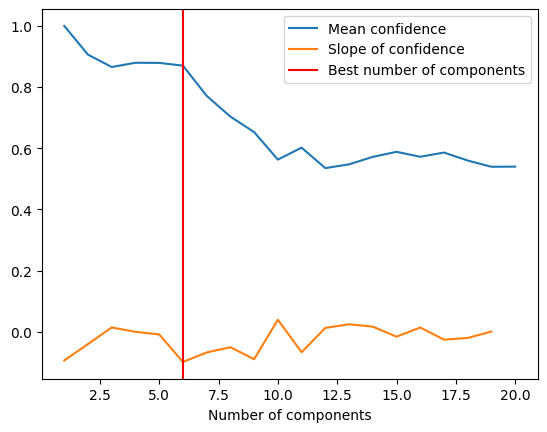

Best number of components for data 6: 6


/Users/mohamad/PycharmProjects/MastersThesis/venv/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

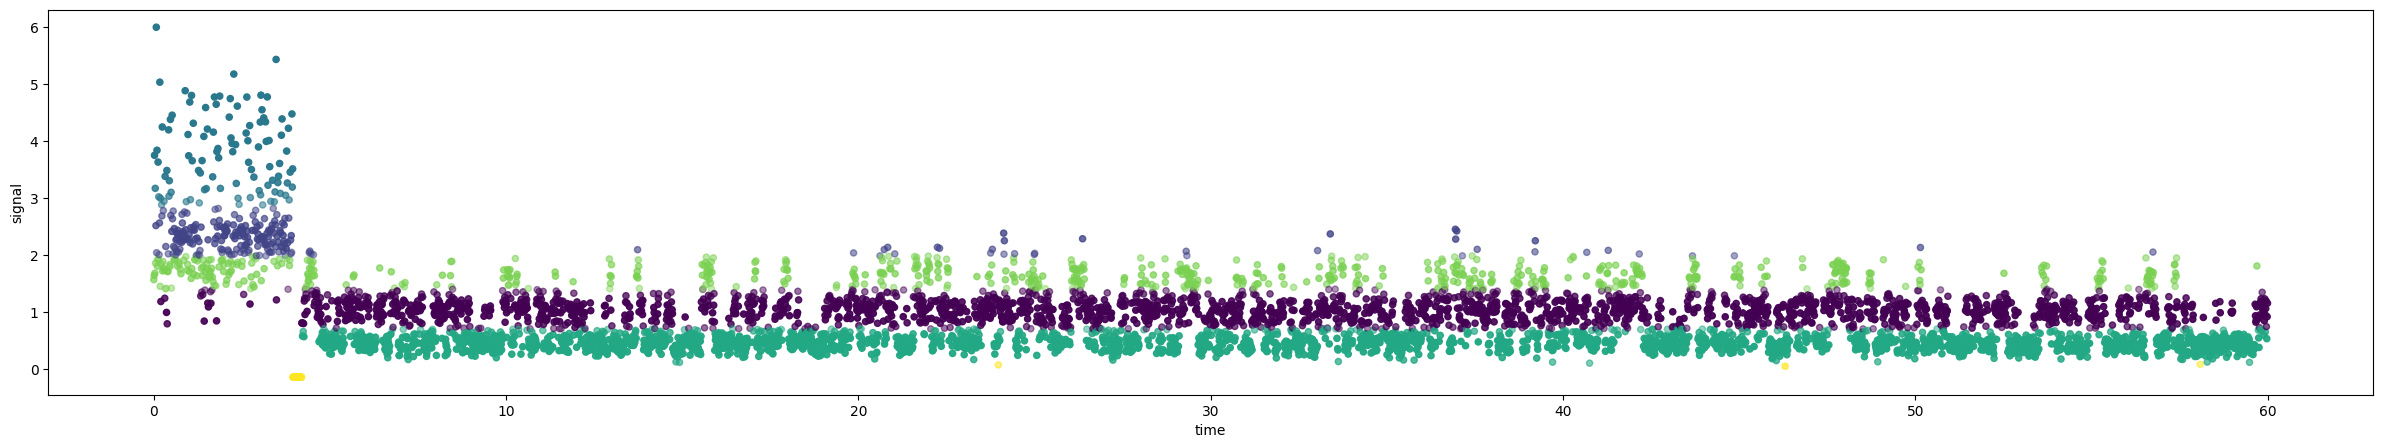

-----------------------------------


/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

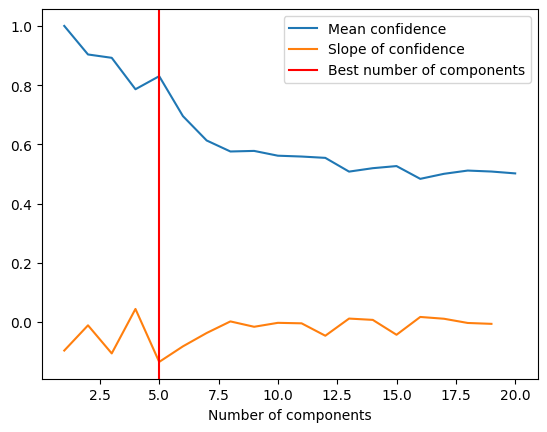

Best number of components for data 7: 5


/Users/mohamad/PycharmProjects/MastersThesis/venv/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

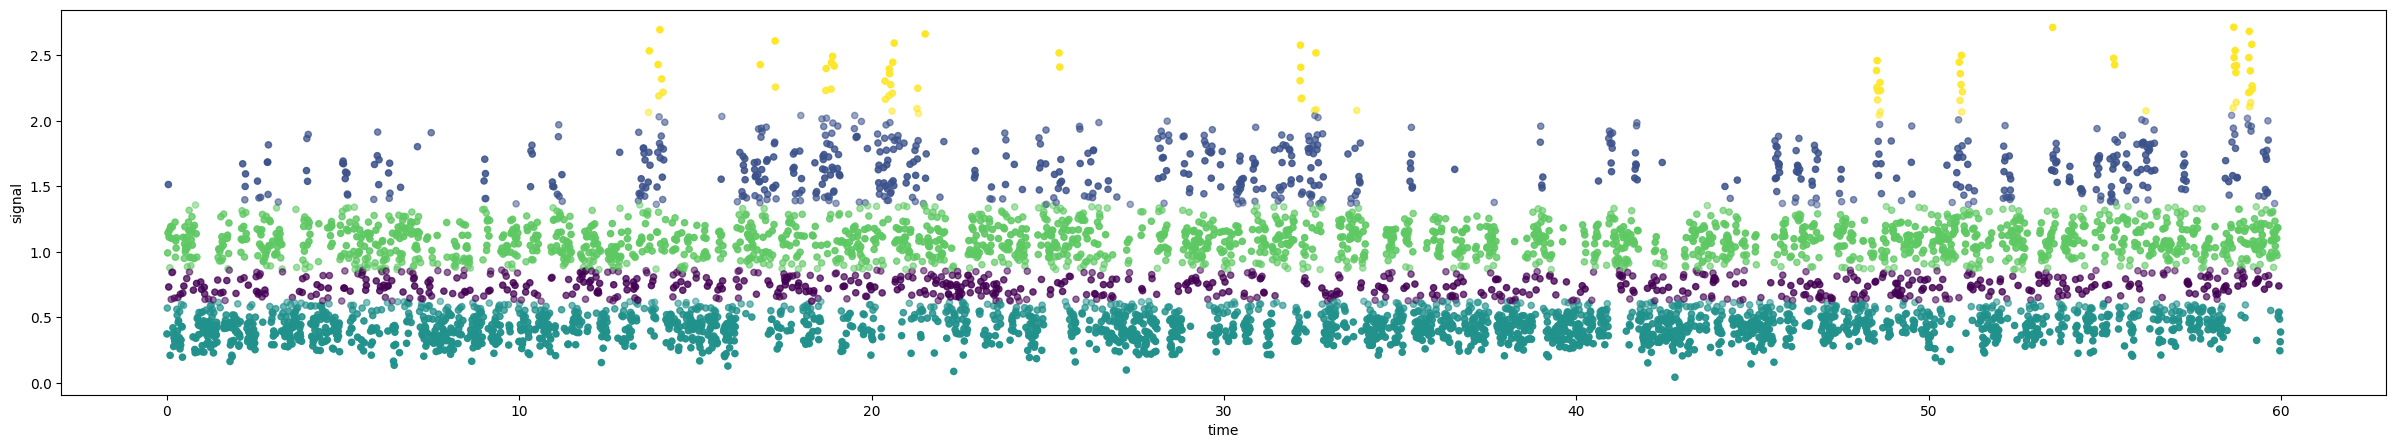

-----------------------------------


/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

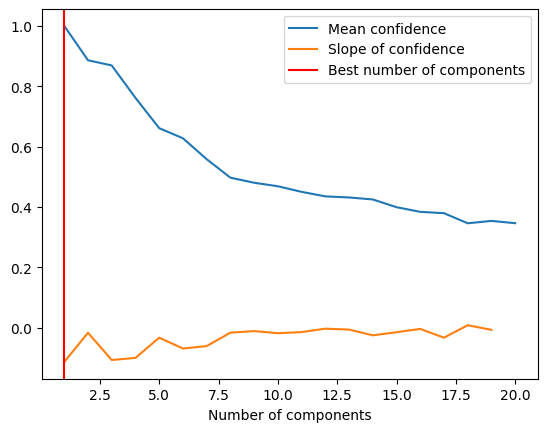

Best number of components for data 8: 1


/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]


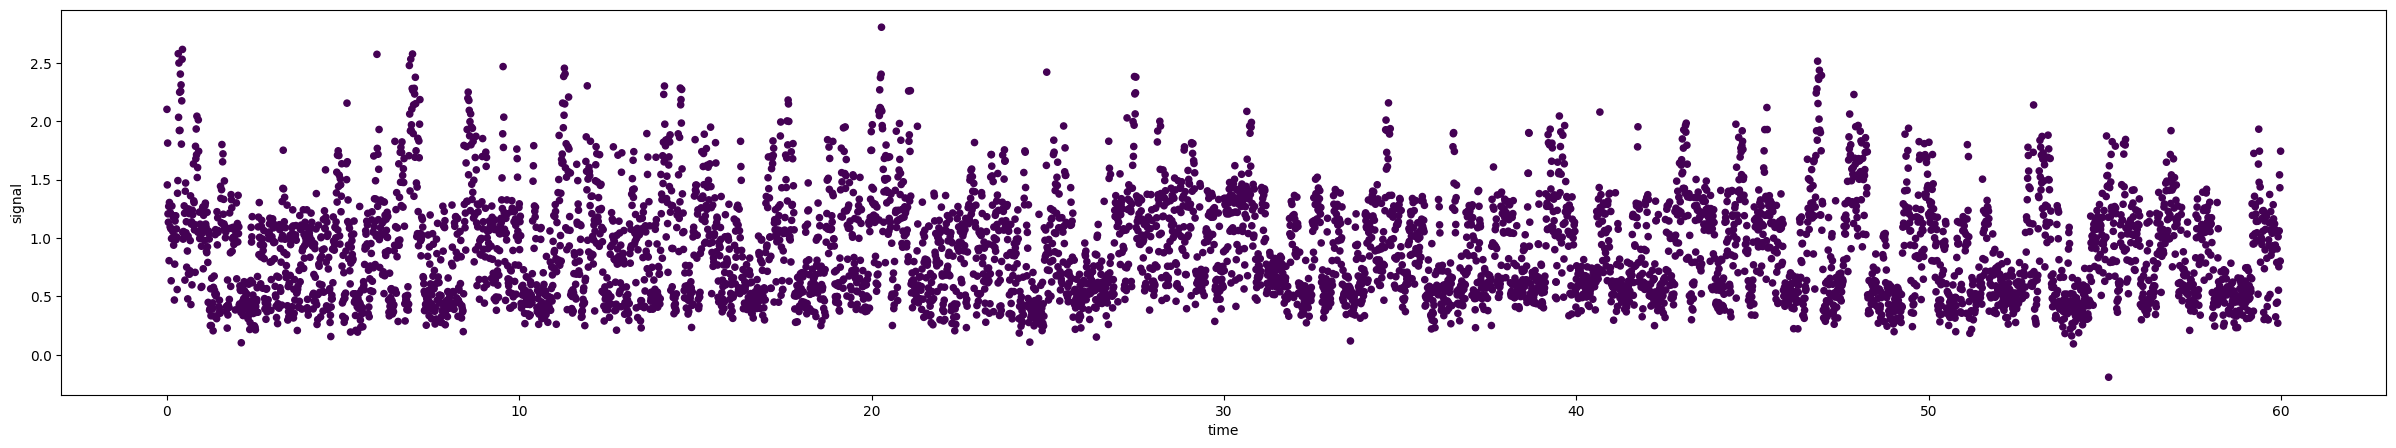

-----------------------------------


/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

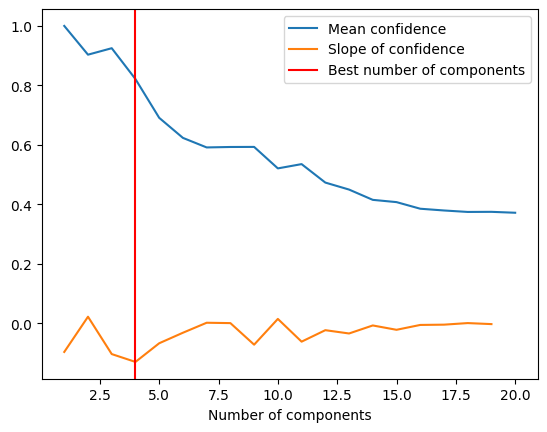

Best number of components for data 9: 4


/Users/mohamad/PycharmProjects/MastersThesis/venv/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

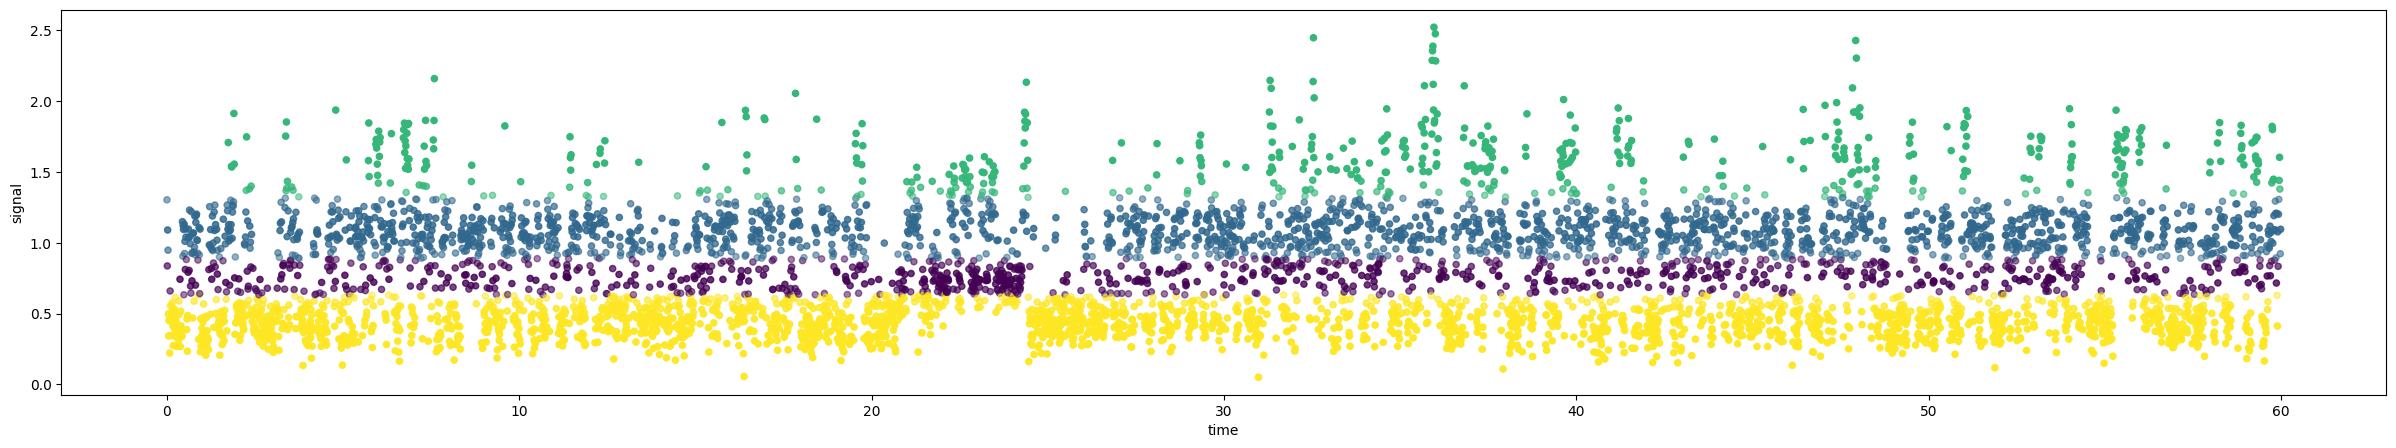

-----------------------------------


/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/Users/mohamad/PycharmProjects/MastersThesis/venv/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increa

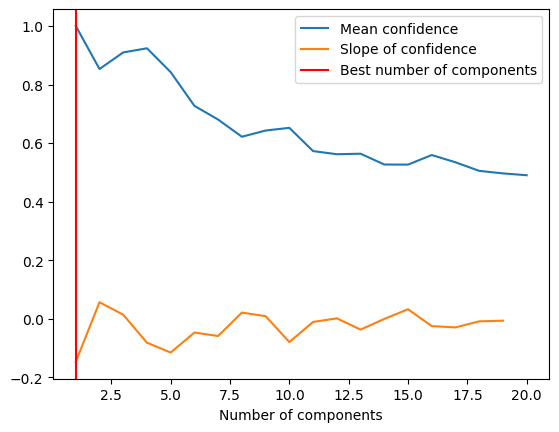

Best number of components for data 10: 1


/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/2689322445.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]


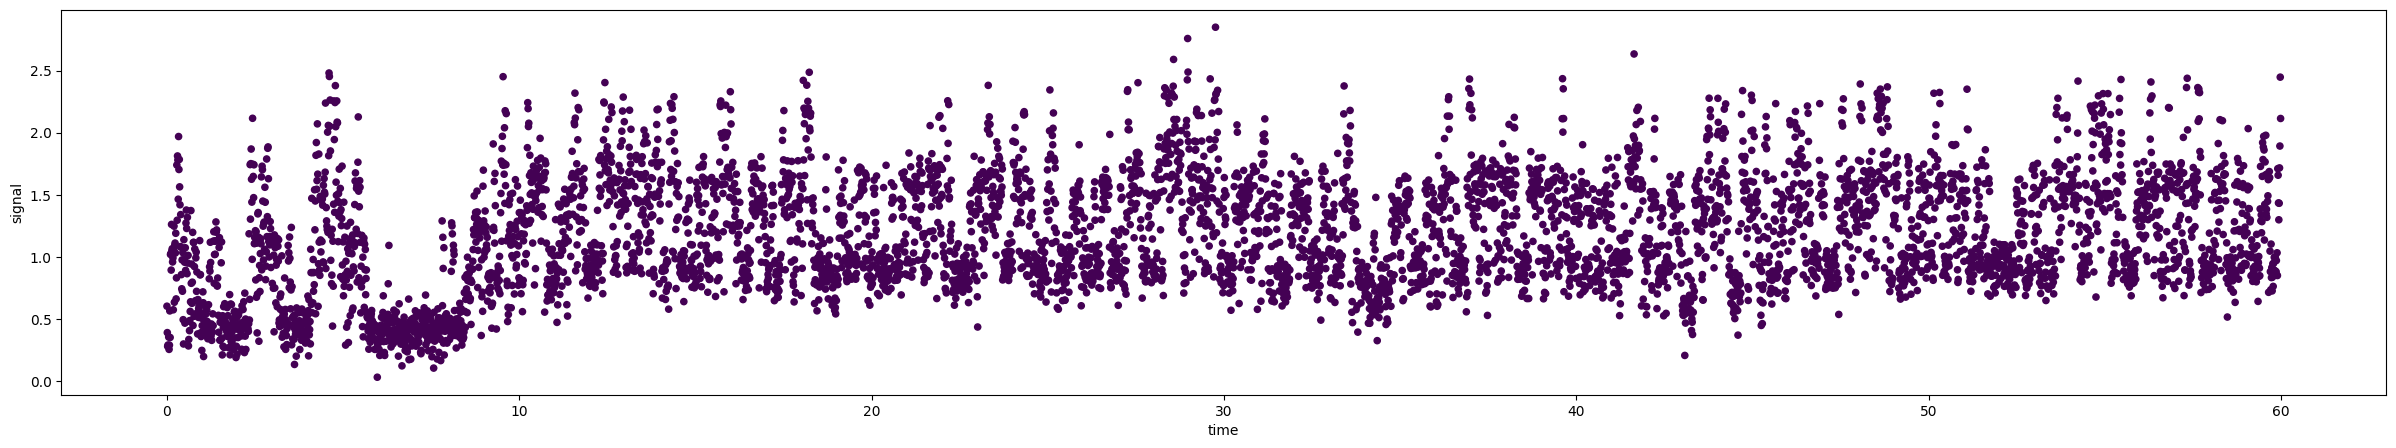

-----------------------------------


In [226]:
for state_index in range(1):
    n_components = get_best_n_components(data_index=state_index)
    print(f'Best number of components for data {state_index}: {n_components}')
    get_graph(data_index=state_index, n_components=n_components)
    print('-----------------------------------')

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

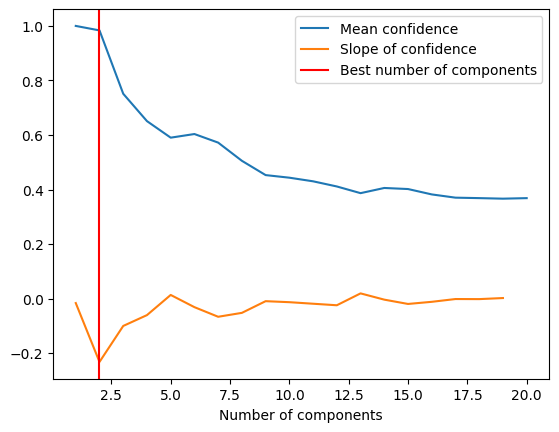

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

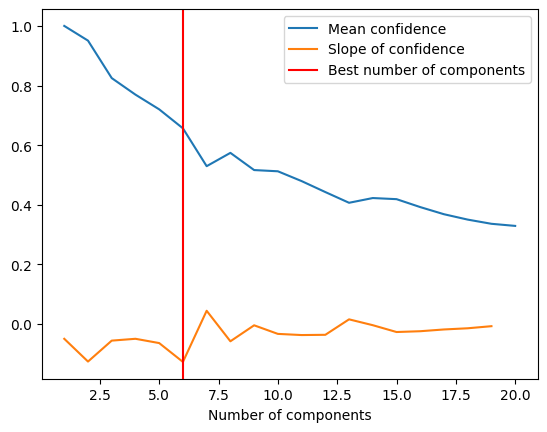

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

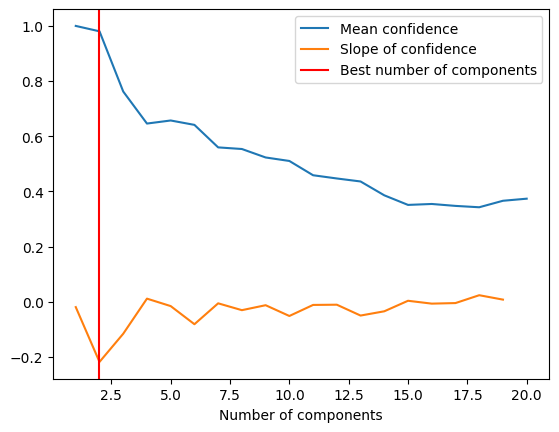

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

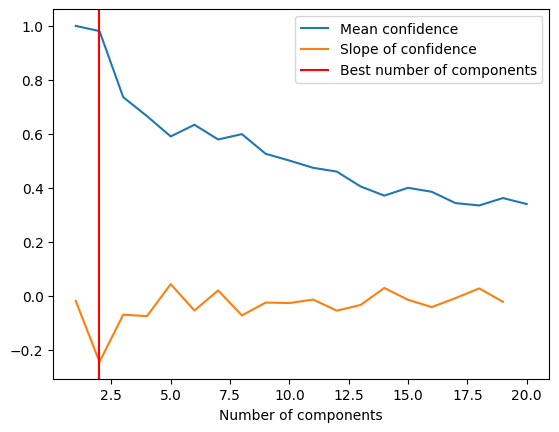

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

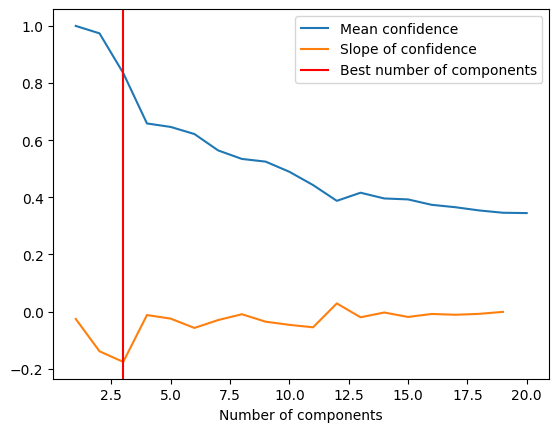

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

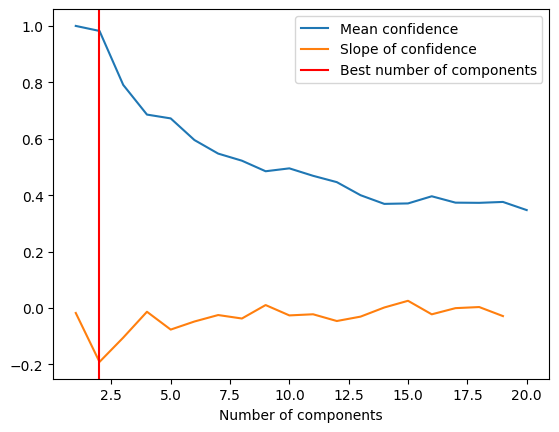

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

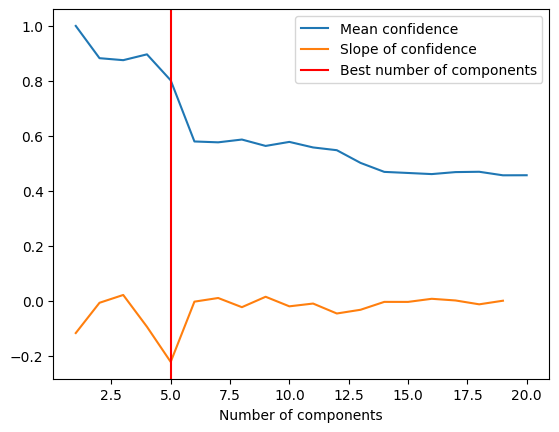

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

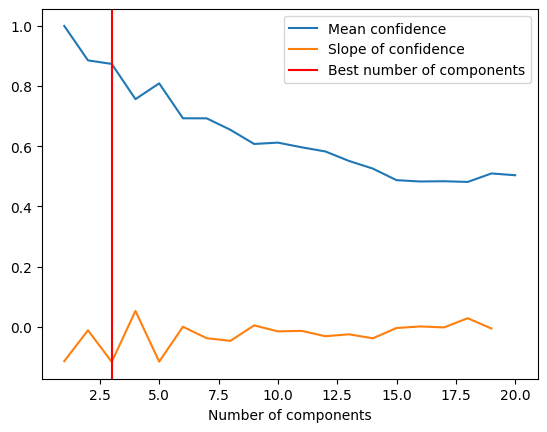

/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = predicted
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conf'] = conf[:, 0]
/var/folders/nz/2mq8cb7968z_6dl9qq938gbc0000gp/T/ipykernel_24000/3769525421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

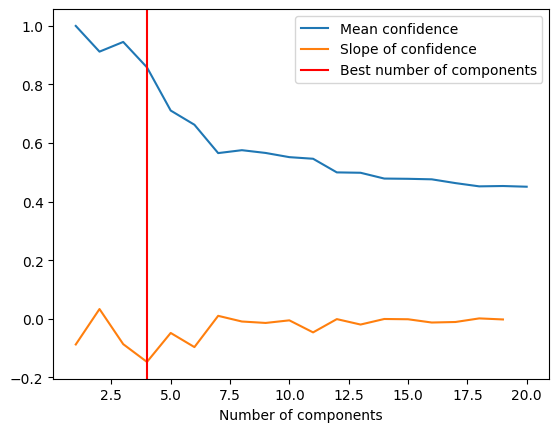

25


In [236]:
for state_index in range(17, 50):
    n_components = get_best_n_components(data_index=state_index)
    if n_components == 4:
        print(state_index)
        break